<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/nutr__all_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ②f_nutr1シートのE_CR～E_SSまでの１７食品群別エネルギー<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

In [1]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


### 関数定義

In [4]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [5]:
# # 特定の変数と他の変数との相関を確認
# def targetCorrMatrix(df):
#   df = 'VEG3'
#   correlations = values_dataframe.corrwith(values_dataframe[df])
#   correlations.sort_values(ascending=False)

In [6]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [9]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [10]:
def checksVariables(df):
  # # non-zeroのデータ数を確認
  # countZeroData(df)
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # 各変数の分布を確認
  # distribution(df)

### データ前処理

In [11]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_fnutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [12]:
print(len(data_nutr),len(data_fnutr1))

3329 3347


## ↓idの重複削除、結合

In [13]:
# data_fnutr1重複を確認
print("data_fnutr1 で重複のある行数:", data_fnutr1['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_fnutr1 で重複のある行数: 136
data_nutr で重複のある行数: 116


In [14]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [15]:
# 左結合
merged_data = pd.merge(data_fnutr1, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3347 entries, 0 to 3346
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 9.0+ MB
None


In [16]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

136

In [17]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
3211


In [18]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3211 entries, 0 to 3302
Columns: 352 entries, ID1 to filename_y
dtypes: float64(322), int64(26), object(4)
memory usage: 8.6+ MB
None
3211


### ↓変数作成


In [19]:
## エネルギー補正係数とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加(ECF:Energy correction factor)
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['ECF'] = cleaned_data_copy['EER'] / cleaned_data_copy['EN']

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,W_CR,W_PT,W_SG,W_PL,W_GV,W_OV,W_FR,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,ECF
0,201100005,2015.0,11,303.195981,27.717256,8.135054,144.377205,145.014042,111.979363,268.098456,...,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,22.340297,1.231252


In [20]:
# 変数を選択
selected_columns = cleaned_data_copy.loc[:, 'E_CR':'E_SS'].copy()
selected_columns['BMI'] = cleaned_data_copy['BMI']
selected_columns['ECF'] = cleaned_data_copy['ECF']
selected_columns['AGE'] = cleaned_data_copy['AGE']
selected_columns['SEX'] = cleaned_data_copy['SEX']
values_dataframe = selected_columns

values_dataframe.describe()

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF,AGE,SEX
count,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3211.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.571548,50.411233,18.212708,73.328395,32.447372,38.622535,45.711714,145.961651,137.943696,62.759368,143.407969,96.285807,179.458348,120.820796,54.307191,22.312986,1.255976,47.716963,1.606061
std,367.152819,44.818075,14.877232,54.599812,22.708942,25.633737,46.285147,122.277501,87.598725,40.147394,122.020847,53.547513,162.579887,177.117455,36.027271,3.649318,0.476263,22.889282,0.488698
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,0.259846,10.000000,1.000000
25%,495.650412,17.691071,7.812617,30.781927,16.613035,20.654462,12.303194,63.145533,82.901157,35.060232,56.324967,59.048827,62.329747,19.529291,29.027599,19.735976,0.952504,25.000000,1.000000
50%,666.067491,42.551282,15.032625,61.333836,27.118384,33.100241,32.739018,111.759260,126.005859,56.948571,116.335714,88.581030,137.361087,46.464286,46.618420,21.953125,1.168960,53.000000,2.000000
75%,851.336016,69.686258,24.072308,105.481068,42.860439,50.234088,63.991357,191.924707,169.401280,90.432496,193.928571,126.588080,245.750421,130.637962,73.753514,24.444444,1.441831,67.000000,2.000000
max,5202.143086,330.233334,141.620005,432.728702,177.452680,178.625893,431.759097,1192.206400,951.942218,253.210990,1234.340143,588.183023,1672.645467,2011.630053,261.886802,50.781250,5.894433,96.000000,2.000000


In [21]:
# NA処理
values_dataframe_cleaned = values_dataframe.dropna()

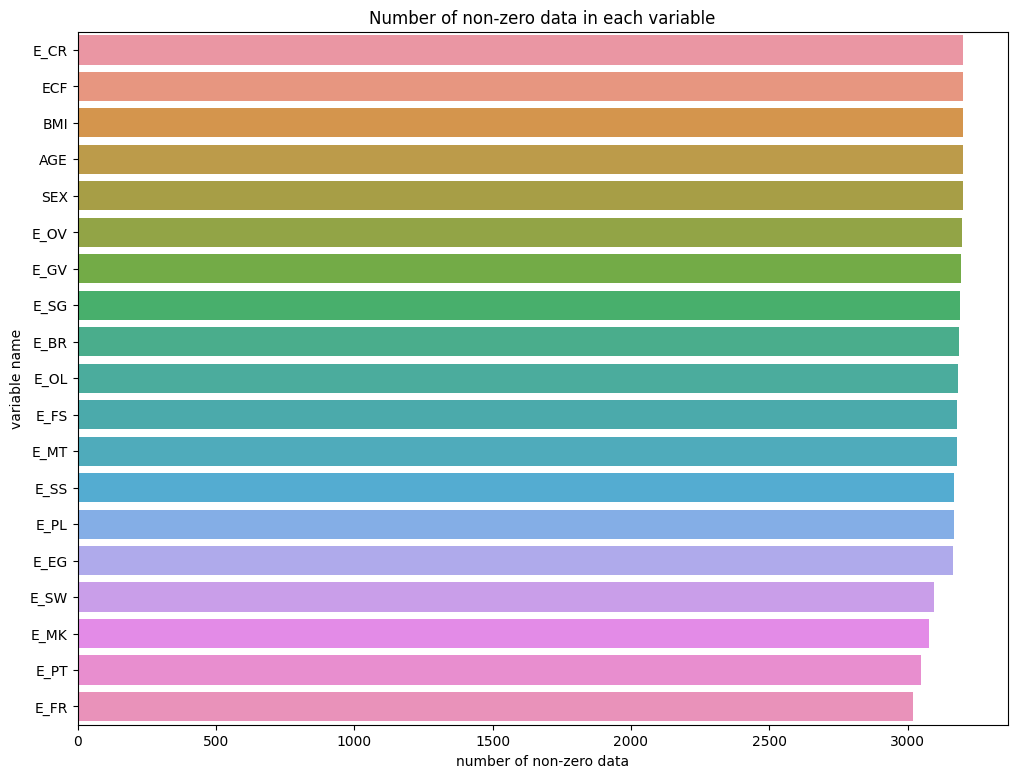

('E_GV', 'E_OV', 0.7040129248500424)
('E_GV', 'E_FR', 0.567757844868274)
('E_OV', 'E_GV', 0.7040129248500424)
('E_FR', 'E_GV', 0.567757844868274)
('E_MT', 'E_OL', 0.5948509316936996)
('E_OL', 'E_MT', 0.5948509316936996)


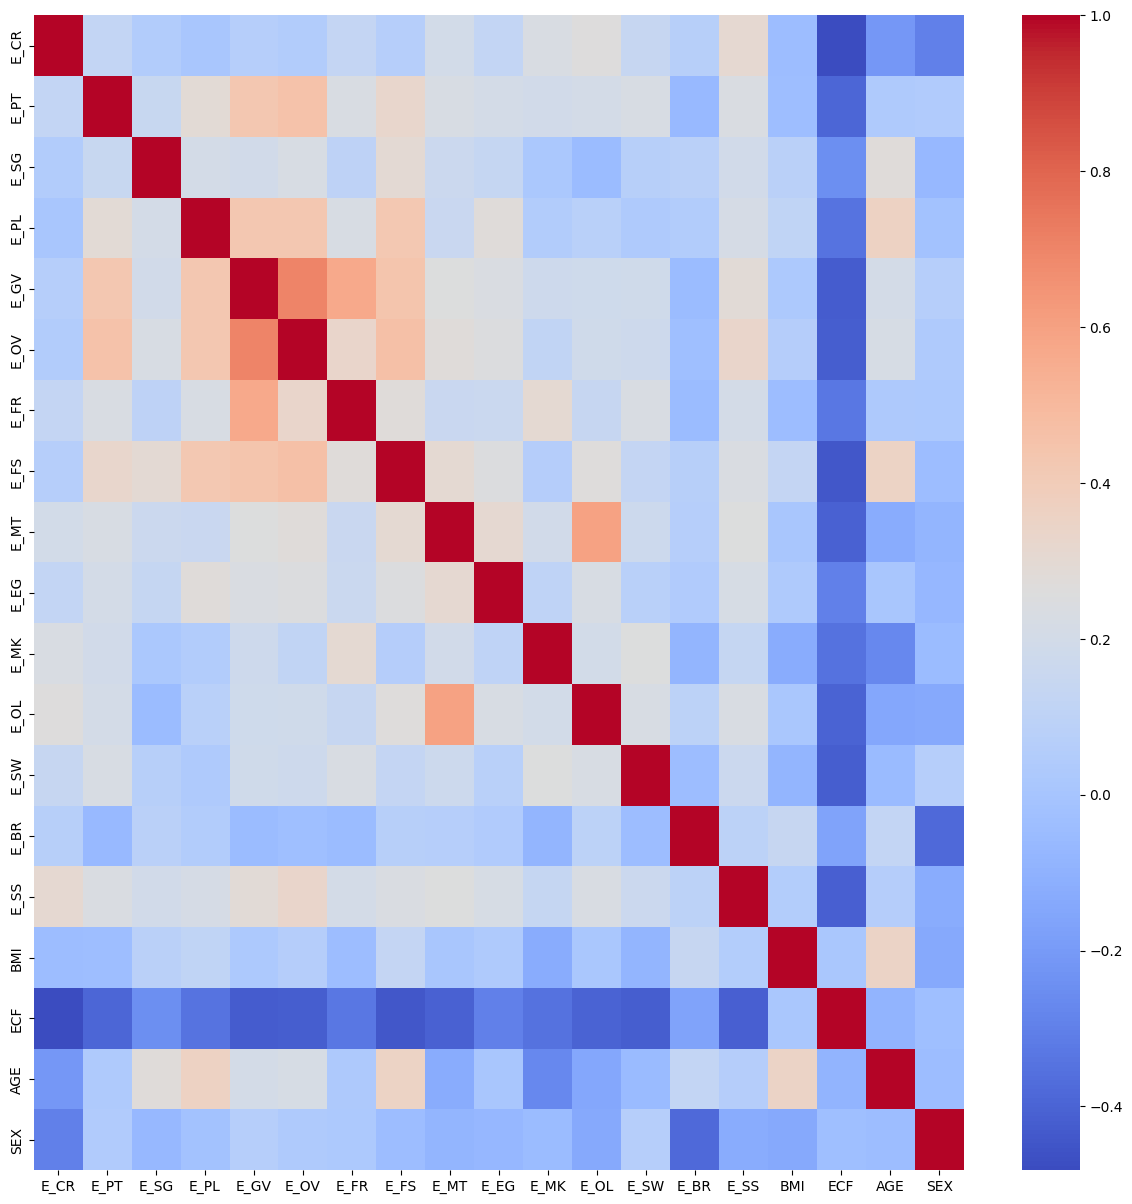

In [22]:
checksVariables(values_dataframe_cleaned)

### LiNGAMの関数定義

In [23]:
# 解析に使用する変数の選択（）
def select(df):
    # 基本統計量の確認
    df.describe()

    # 各列について、上:0.5%,下:0.5%のデータを外れ値として除去
    for column in df.columns:
        lower_limit = df[column].quantile(0.005)
        upper_limit = df[column].quantile(0.995)
        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # 修正されたデータフレームを表示
    df.describe()

    len(df)

    return df

In [24]:
def modeling(selected_columns):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(selected_columns)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果の順番
  print(f"因果の順番\n{model.causal_order_}\n\n")

  # 隣接行列
  print(f"隣接行列\n{model.adjacency_matrix_}\n\n")

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  print(f"推定した因果モデルにおける、誤差同士の独立性のp値\n{p_values}\n\n")

  return model

In [25]:
def gragh(model, selected_columns,dagname):
    # 因果グラフの描画
    dot = make_dot(model.adjacency_matrix_, labels=selected_columns.columns.to_list())
    dot.format = 'png'
    dot.render(dagname)
    return dot

In [26]:
def lingam_matrix(df):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=100)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, 100, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, 100, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    causal_df = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    causal_df['from'] = causal_df['from'].apply(lambda x: labels[x])
    causal_df['to'] = causal_df['to'].apply(lambda x: labels[x])
    return causal_df

In [27]:
def LiNGAM(df,dagname):
  selected_columns = select(df)
  model = modeling(selected_columns)
  dot = gragh(model, selected_columns,dagname)
  re_df = lingam_matrix(selected_columns)
  return dot,re_df

In [28]:
print(values_dataframe_cleaned.columns.tolist())

['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF', 'AGE', 'SEX']


##16変数

In [29]:
# 変数を指定するリスト(16)
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_OV', 'E_FR', 'E_FS', 'E_MT', 'E_EG', 'E_MK', 'E_OL', 'E_SW', 'E_BR', 'E_SS', 'BMI', 'ECF']

# 使用する変数を確認
df = values_dataframe_cleaned[selected_variables]
df

,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF
0,611.084509,23.588095,31.238608,109.454936,38.207538,22.599505,110.037211,147.662474,136.211597,49.326816,355.077844,106.064037,222.419231,119.508270,110.409701,22.340297,1.231252
1,1013.089369,108.112104,16.799413,76.333603,23.460290,57.120557,13.387874,69.150696,181.621688,90.432496,398.285416,164.775112,261.748154,111.844019,128.299368,29.384757,0.980858
2,884.323748,19.656746,16.524739,10.909131,23.471166,30.071318,37.378482,57.835753,104.559746,115.095904,182.983383,107.696120,198.404738,47.798626,25.686451,19.568236,1.422898
3,1601.708395,58.970238,13.653344,13.090957,39.616248,52.605939,0.000000,348.983795,377.546144,138.115085,43.159727,209.556884,392.420910,179.581684,128.894541,25.854639,0.736540
4,901.041993,108.112104,26.510148,46.333493,41.543150,39.087465,93.085499,483.138811,224.499225,126.605495,199.094038,164.263920,208.421309,96.885391,116.787423,23.214198,0.934649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,873.240080,18.701970,0.103321,67.972343,1.736734,0.000000,9.105204,20.382684,89.726897,107.104834,411.826698,8.055577,0.000000,11.019537,51.610540,15.061332,1.212149
3297,946.092537,63.941622,12.141975,97.234974,41.916822,44.823921,127.511899,102.211936,146.941214,98.275572,465.925694,95.514960,369.883019,262.502079,62.116778,15.320256,0.629887
3300,597.962406,22.231925,2.959305,6.508316,3.414781,5.591090,3.898818,24.556627,47.195073,14.039367,54.448262,39.113056,164.069386,250.066547,28.135001,18.668680,1.463388
3301,2026.844164,48.312578,16.374471,62.274240,37.475639,37.333737,147.658258,233.741491,243.018304,76.503453,769.581669,208.171341,200.073685,91.998357,71.471038,19.113632,0.473432


In [30]:
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]

# 結果を表示
print(df_filtered.describe())

              E_CR         E_PT         E_SG         E_PL         E_GV  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean    725.025968    54.122600    18.269948    74.639550    34.210648   
std     359.131586    44.767724    14.080011    54.038812    22.484622   
min      36.355230     5.071666     0.068914     3.526533     0.323022   
25%     508.129195    19.656746     8.251870    32.825087    18.424736   
50%     670.418195    44.227679    15.253344    61.333836    29.045626   
75%     852.324109    76.592308    24.135243   108.091883    44.586210   
max    5202.143086   330.233334   116.520544   432.728702   166.758571   

              E_OV         E_FR         E_FS         E_MT         E_EG  \
count  2690.000000  2690.000000  2690.000000  2690.000000  2690.000000   
mean     40.305422    49.802944   150.816267   142.783395    63.520024   
std      25.546569    46.826715   123.033226    87.506299    38.828927   
min       0.233749     2.560000     4

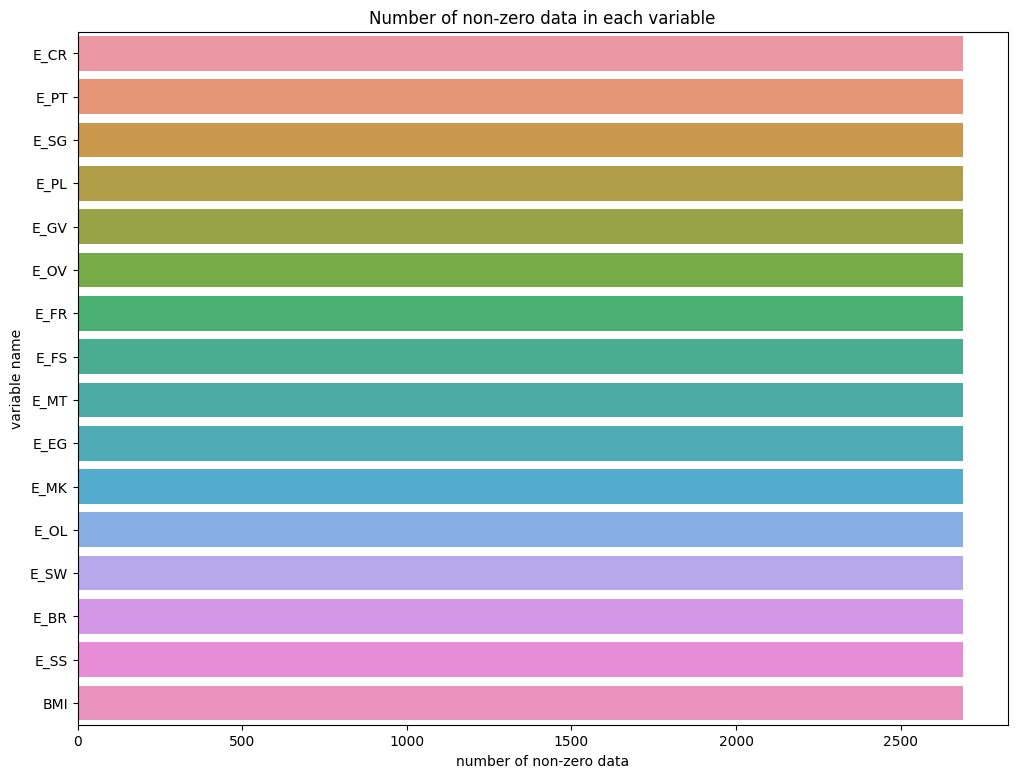

('E_GV', 'E_OV', 0.6107364840219336)
('E_OV', 'E_GV', 0.6107364840219336)


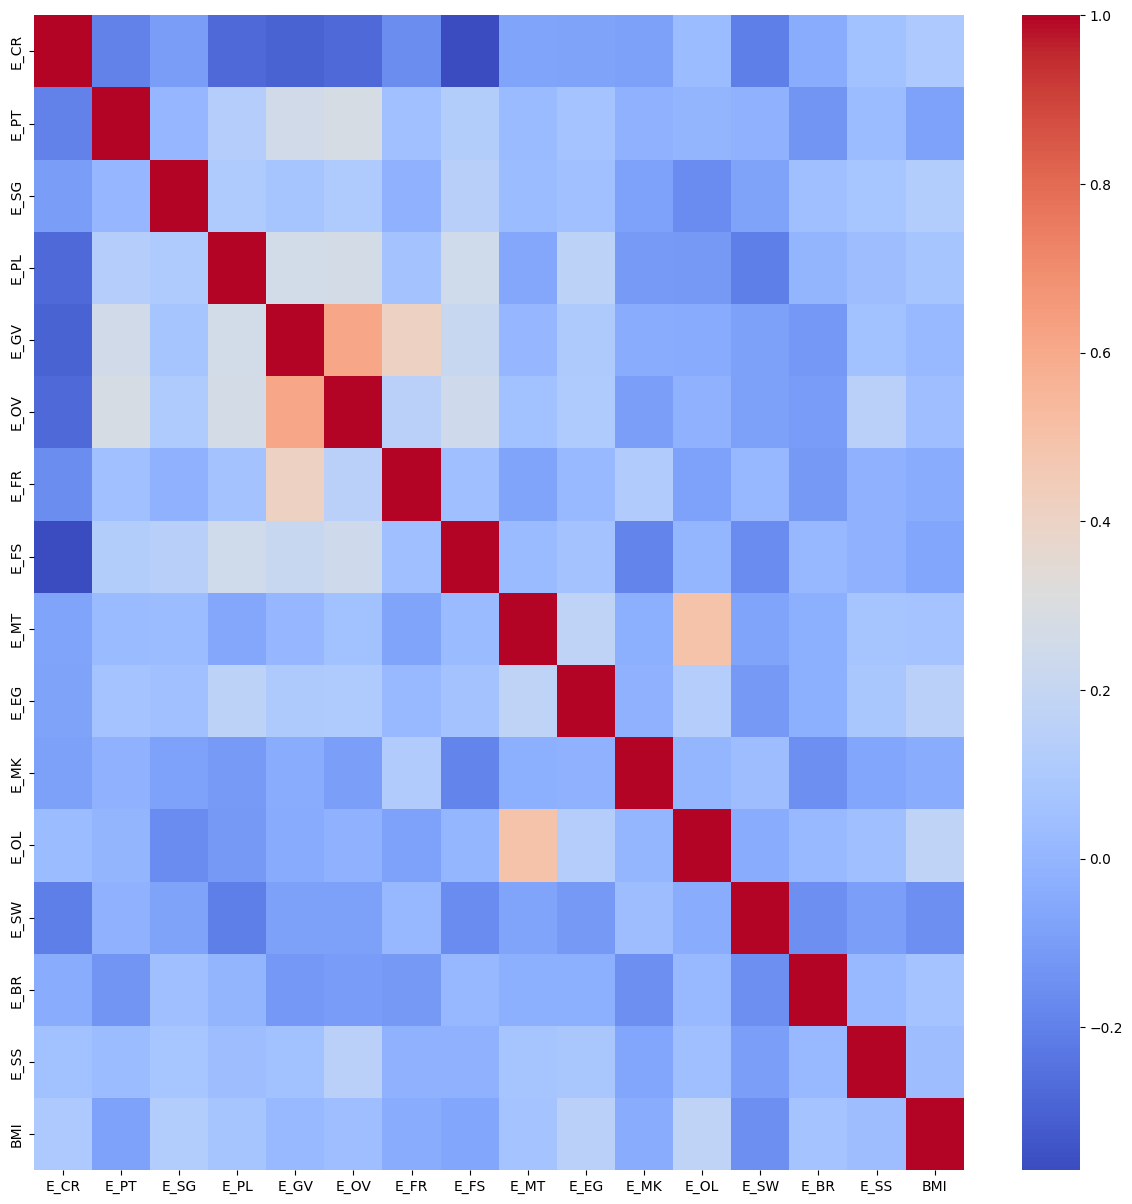

In [31]:
# ECF列を掛ける
multiplied_df_filtered = df_filtered.drop('ECF', axis=1).multiply(df_filtered['ECF'], axis=0)
# print(multiplied_df_filtered.describe())
checksVariables(multiplied_df_filtered)

因果の順番
[11, 14, 8, 9, 13, 12, 10, 7, 6, 4, 3, 2, 15, 1, 5, 0]


隣接行列
[[ 0.         -0.08914327 -0.03782192 -0.21702604 -0.13639429 -0.08981406
  -0.07833309 -0.29538756 -0.09299839  0.         -0.19721825  0.04250163
  -0.31726947 -0.12520964  0.06747814  0.07181577]
 [ 0.          0.          0.          0.          0.22756182  0.
  -0.06542487  0.07234431  0.          0.0504737   0.          0.
   0.         -0.09569206  0.         -0.08769254]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.14655208  0.15277151  0.          0.         -0.28742239
   0.          0.          0.0867366   0.        ]
 [ 0.          0.          0.          0.          0.17951177  0.
   0.          0.16386215 -0.06032599  0.10947752 -0.08372028 -0.1222622
  -0.13899766  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.37342272  0.14850272  0.          0.06319009 -0.06384214 -0.03963088
  -0.09230012 -0.1074742   0.

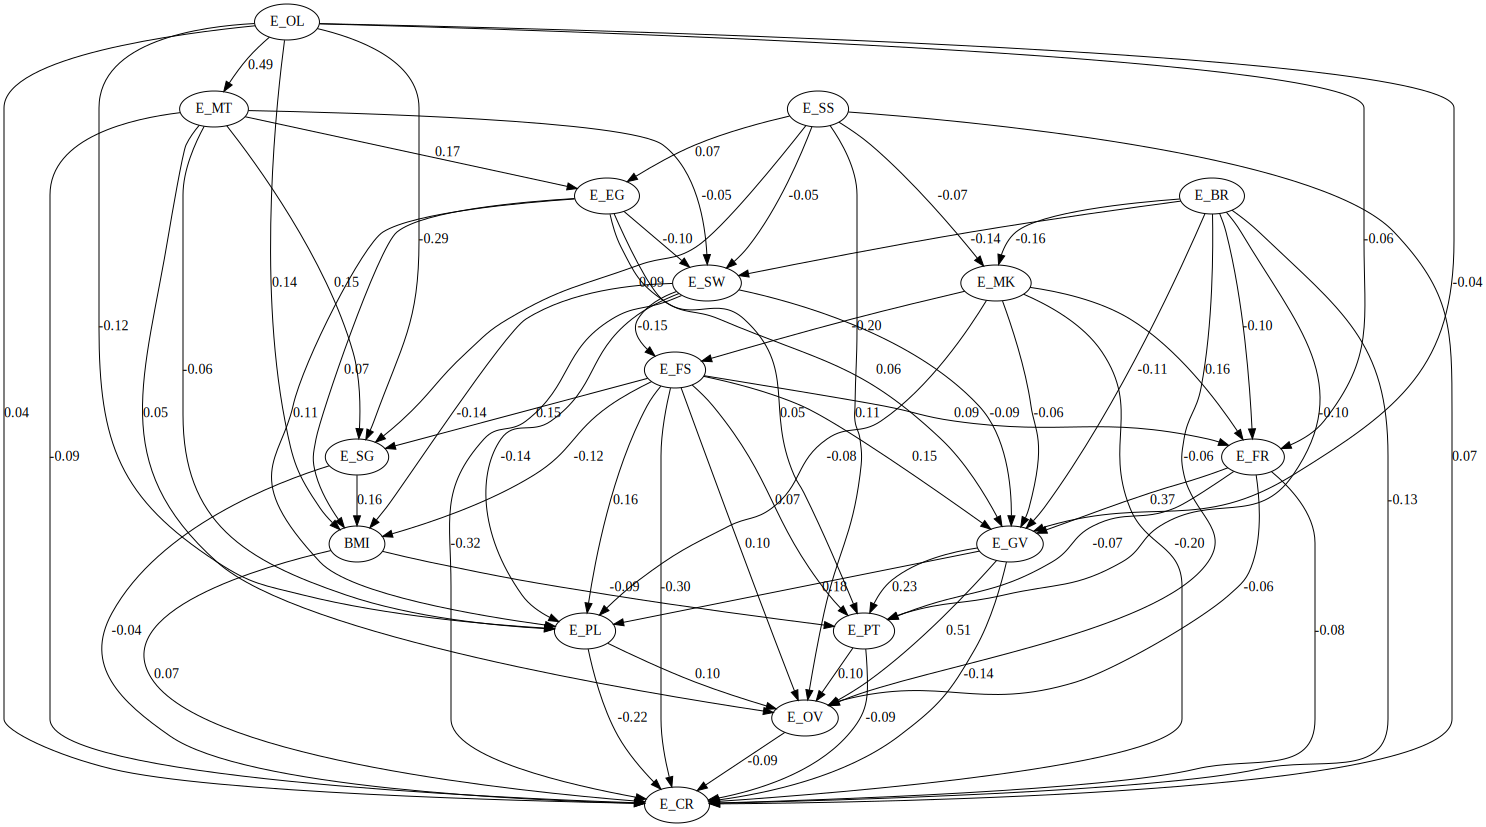

In [32]:
dot,causal_df = LiNGAM(multiplied_df_filtered,'nutr_all_data_allvar')
dot

In [33]:
causal_df[causal_df['to']=='BMI']

,from,to,effect,probability
15,E_OL,BMI,0.123126,0.98
24,E_SW,BMI,-0.141204,0.88
26,E_FS,BMI,-0.096242,0.87
28,E_SG,BMI,0.160229,0.86
29,E_EG,BMI,0.085090,0.86
61,E_BR,BMI,0.074851,0.48
63,E_PL,BMI,0.068395,0.46
70,E_FR,BMI,-0.061664,0.40
81,E_MT,BMI,0.078589,0.29
86,E_SS,BMI,0.071776,0.26


## 8変数

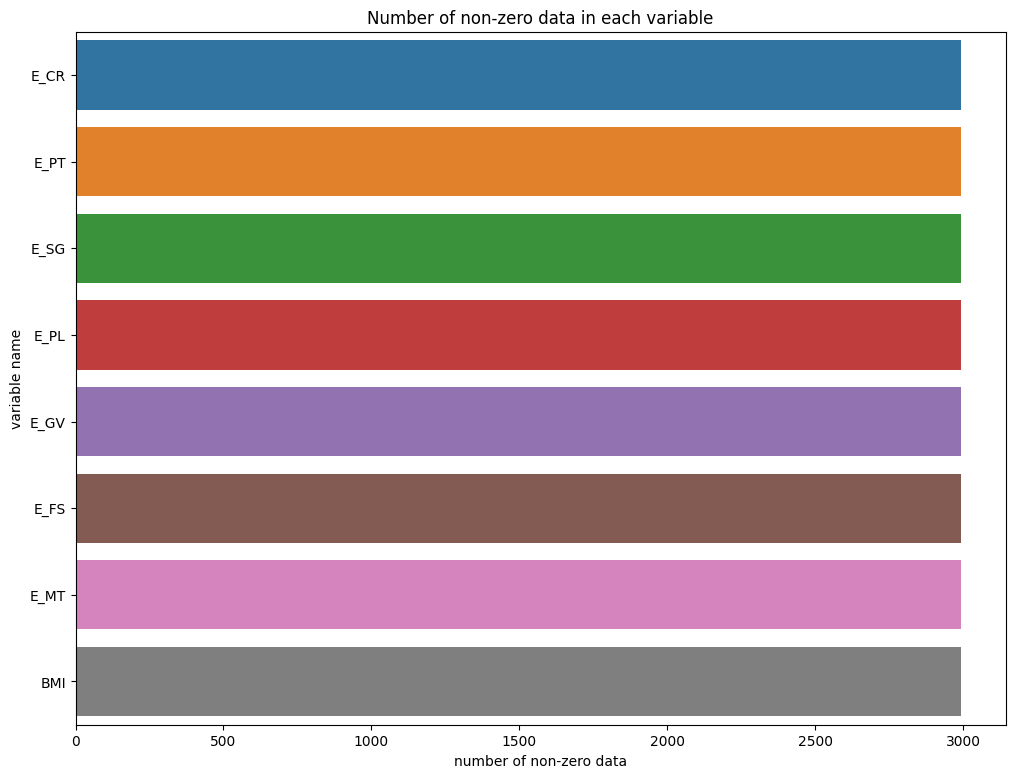

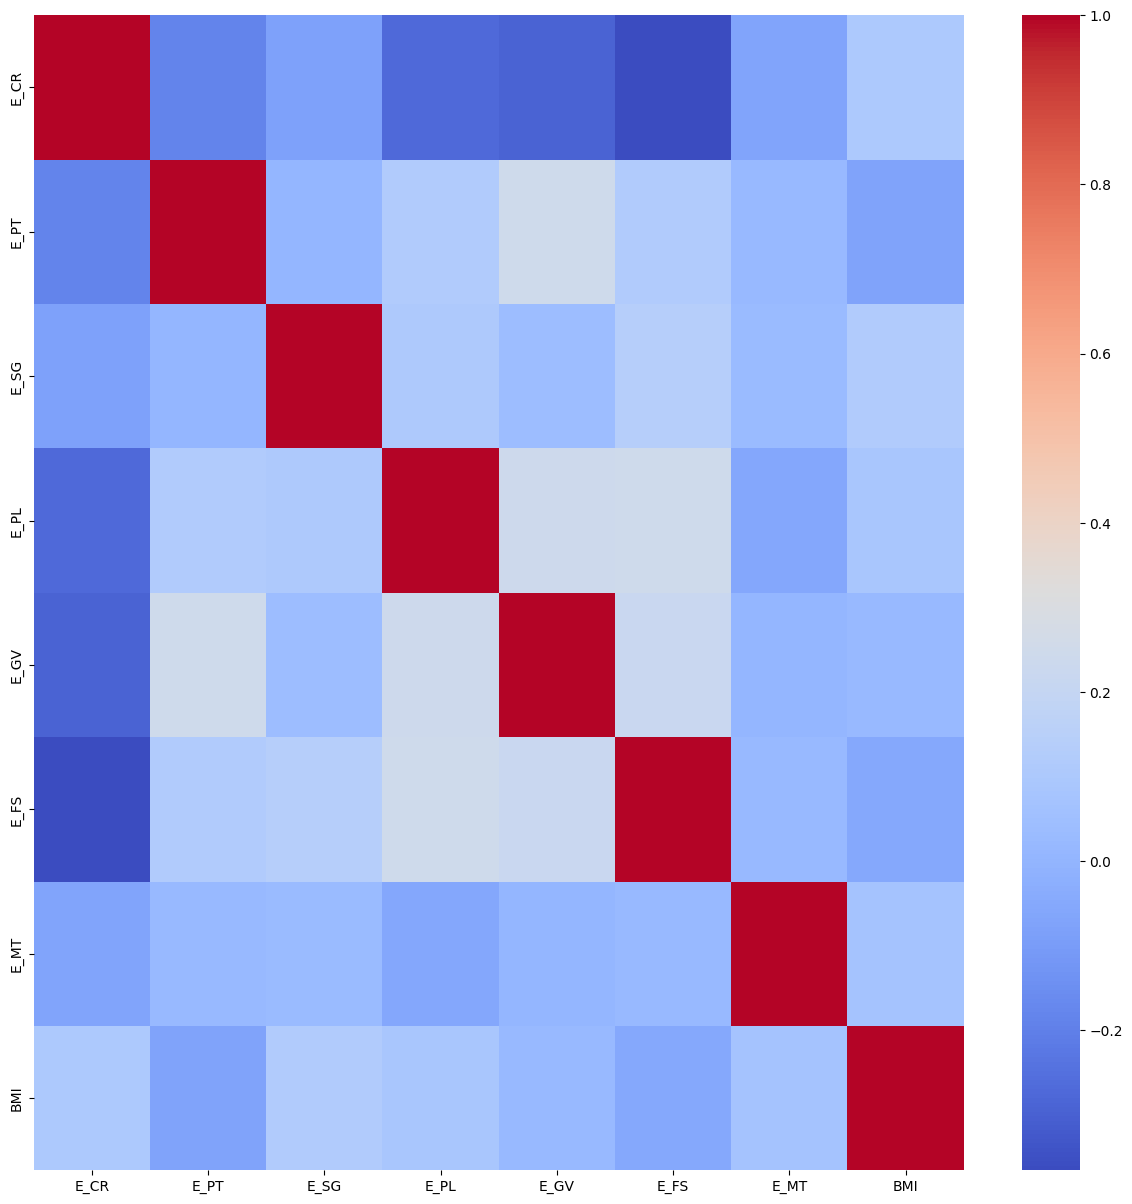

因果の順番
[5, 4, 6, 2, 3, 7, 1, 0]


隣接行列
[[ 0.         -0.07587756  0.         -0.16027934 -0.16989328 -0.24486002
  -0.05437247  0.11921851]
 [ 0.          0.          0.          0.05783832  0.22268185  0.05616901
   0.         -0.08157273]
 [ 0.          0.          0.          0.          0.          0.13741096
   0.          0.        ]
 [ 0.          0.          0.07318073  0.          0.21165769  0.18754996
  -0.0676133   0.        ]
 [ 0.          0.          0.          0.          0.          0.18753221
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.11922007  0.05025689  0.         -0.09682638
   0.07841623  0.        ]]


推定した因果モデルにおける、誤差同士の独立性のp値
[[0.00000000e+00 7.50035024e-02 9.08148710e-02 1.56915302e-01
  8.74217126e-04 7.56669375e-03 1.38769744e-03 2.60515370e-07]
 [7.50035024e-02

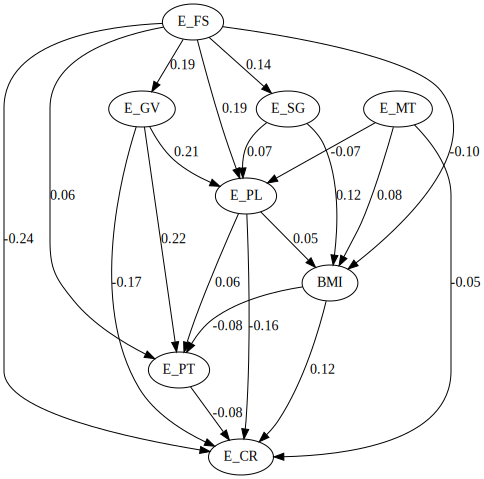

In [34]:
# 変数を指定するリスト(8)
selected_variables = ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_FS', 'E_MT', 'BMI', 'ECF']
df = values_dataframe_cleaned[selected_variables]
# 0data削除
df_filtered = df[(df != 0).all(axis=1)]
# ECF列を掛ける
multiplied_df_filtered = df_filtered.drop('ECF', axis=1).multiply(df_filtered['ECF'], axis=0)
checksVariables(multiplied_df_filtered)
dot,causal_df = LiNGAM(multiplied_df_filtered,'nutr_all_data_8var')
dot

In [35]:
causal_df[causal_df['to']=='BMI']

,from,to,effect,probability
1,E_SG,BMI,0.123552,1.00
8,E_MT,BMI,0.081081,0.91
11,E_FS,BMI,-0.072686,0.76
13,E_PL,BMI,0.070947,0.67
18,E_CR,BMI,0.135925,0.48
35,E_PT,BMI,-0.086285,0.04
41,E_GV,BMI,0.042843,0.01
